# cifar10 ViT finetune 0.979


## Подготовка данных



In [ ]:
!pip install datasets transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.4 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from transformers import ViTFeatureExtractor
from datasets import load_metric
from transformers import TrainingArguments
from transformers import ViTForImageClassification
import sys
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import Trainer

In [ ]:
#set up rinning devise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# donloading datasets
dataset_train = load_dataset(
    'cifar10',
    split='train',
    ignore_verifications=False
)

dataset_train

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2562: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [ ]:
dataset_test = load_dataset(
    'cifar10',
    split='test',
    ignore_verifications=False
)

dataset_test

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2562: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=all_checks' instead.
  warnings.warn(


Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [ ]:
#check labels
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label']
num_classes, labels

(10,
 ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None))

## Модель

In [ ]:
# import model
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
#create transform for data
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor( #vit feature extractor
        batch['img'],
        return_tensors='pt'
    )
    # include the labels
    inputs['label'] = batch['label']
    return inputs

In [ ]:
# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# transform the testing dataset
prepared_test = dataset_test.with_transform(preprocess)

In [ ]:
def collate_fn(batch): # create dictionary { pixels, label }
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [ ]:
metric = load_metric("accuracy", trust_remote_code=True) # create validation metric
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

<ipython-input-10-5401ba2f51cd>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


In [ ]:
training_args = TrainingArguments( #set up training parametrs
  output_dir="./cifar",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=1,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
labels = dataset_train.features['label'].names

model = ViTForImageClassification.from_pretrained( #load model
    model_id,
    num_labels=len(labels)
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device) # move model to gpu

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

## Тренировка модели (Fine-tuning)

In [ ]:
trainer = Trainer( # use training parametrs
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

In [ ]:
train_results = trainer.train()  # 1 epoch train
# save tokenizer with the model
trainer.save_model()
# statistic for model not necessary, but we can use it still
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.429100,0.411839,0.906100
200,0.244000,0.353533,0.905100
300,0.333500,0.362723,0.897800
400,0.266200,0.320930,0.908300
500,0.306400,0.343036,0.901200
600,0.268100,0.330649,0.904200
700,0.229200,0.255756,0.929500
800,0.203600,0.231503,0.932700
900,0.188000,0.180255,0.946700
1000,0.181400,0.212723,0.939400


Step,Training Loss,Validation Loss,Accuracy
100,0.429100,0.411839,0.906100
200,0.244000,0.353533,0.905100
300,0.333500,0.362723,0.897800
400,0.266200,0.320930,0.908300
500,0.306400,0.343036,0.901200
600,0.268100,0.330649,0.904200
700,0.229200,0.255756,0.929500
800,0.203600,0.231503,0.932700
900,0.188000,0.180255,0.946700
1000,0.181400,0.212723,0.939400


***** train metrics *****
  epoch                    =          1.0
  total_flos               = 3608760698GF
  train_loss               =       0.2047
  train_runtime            =   1:45:09.35
  train_samples_per_second =        7.925
  train_steps_per_second   =        0.495


model import / export

---



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #mount my google drive (model exports in folder so we can't just download one file)

Mounted at /content/gdrive


In [ ]:
!cp -r ./cifar /content/gdrive/'My Drive'/'Colab Notebooks'/techSchool/task1/model2 # copy to google d

In [ ]:
!cp -r /content/gdrive/'My Drive'/'Colab Notebooks'/techSchool/task1/model2/cifar ./cifar # copy from google d

## Тестирование модели

In [ ]:
# import our fine-tuned model
model_name_or_path = './cifar/model2/cifar'
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
%%time
# test

correct = 0
datasetForTest = dataset_test

total = 1000
i = 0

with torch.no_grad():
    for data in datasetForTest:
        i +=1
        images, labels = data.values()
        inputs = feature_extractor_finetuned(images, return_tensors="pt") #img to tensor

        logits = model_finetuned(**inputs).logits #prediction
        outputs = predicted_label = logits.argmax(-1).item() #choose higher prediction

        if outputs == labels:
          correct += 1

        sys.stdout.write("\rProgress: %d / %d" % (i, total)) #loading scale
        sys.stdout.flush()

        if i==total: break
print(f'\nAccuracy of the network on the 10000 test images: {100 * correct // total} %')

Progress: 1000 / 1000
Accuracy of the network on the 10000 test images: 97 %
CPU times: user 7min 40s, sys: 1.53 s, total: 7min 42s
Wall time: 7min 52s


## Метрики модели

In [ ]:
#@title model metrics from training step
history_acc = [0.906100,0.905100,0.897800,0.908300,0.901200,0.904200,0.929500,0.932700,0.946700,0.939400,0.937300,0.918500,0.937200,0.947000,0.954400,0.956100,0.960600,0.955600,0.963200,0.958400,0.965200,0.968500,0.969800,0.967100,0.973300,0.972500,0.975300,0.975500,0.978700,0.979000,0.979500]
history_t_loss = [0.429100,0.244000,0.333500,0.266200,0.306400,0.268100,0.229200,0.203600,0.188000,0.181400,0.244900,0.254700,0.132500,0.140500,0.220200,0.314400,0.196700,0.159100,0.086800,0.059200,0.153300,0.036900,0.134000,0.137900,0.097600,0.032600,0.075900,0.058400,0.061700,0.042700,0.116900]
history_val_loss = [0.411839,0.353533,0.362723,0.320930,0.343036,0.330649,0.255756,0.231503,0.180255,0.212723,0.207555,0.263774,0.208926,0.181052,0.154204,0.147220,0.126941,0.150186,0.120883,0.135494,0.117149,0.105202,0.104645,0.106825,0.091630,0.095379,0.081958,0.078540,0.073042,0.070977,0.067418]


In [ ]:
def plot_accuracies(history):
    accuracies = history
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

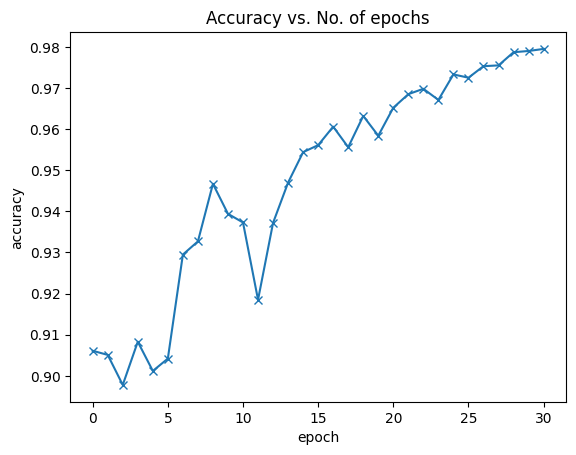

In [ ]:
plot_accuracies(history_acc)

In [ ]:
def plot_losses(t_loss,val_loss):
    train_losses = t_loss
    val_losses = val_loss
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

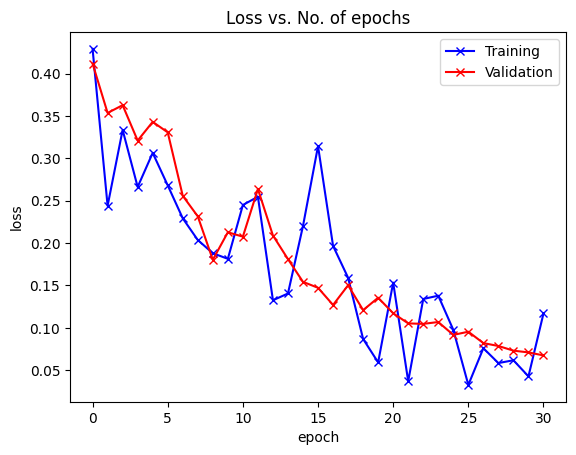

In [ ]:
plot_losses(history_t_loss,history_val_loss)